In [173]:
from keras.layers import RepeatVector
from keras.layers.core import Dropout, Dense, Activation
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

In [174]:
import pandas as pd
import numpy as np
from utils import *

In [175]:
def get_data():
    path = "fastStorage/fastStorage/2013-8/1.csv"
    df = pd.read_csv(path, sep=';\t')
    df = df.drop(['CPU cores', 'Memory capacity provisioned [KB]'], 1)
    if(df.isnull().sum().sum()):
        df = df.fillna(df.mean())
    return df

In [176]:
def get_benchmark():
    path = "ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_60.csv"
    #path = "ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark_all.csv"
    df = pd.read_csv(path, sep=',')
    if(df.isnull().sum().sum()):
        df = df.fillna(df.mean())
    return df

In [177]:
def get_more_benchmark():
    path = "ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_"
    dfs = []
    for i in range(10, 65):
        df = pd.read_csv(path + str(i) + ".csv", sep=',')
        dfs.append(df)

    df = pd.concat(dfs)
    return df

In [178]:
def make_data_windows(data, window_length=12):
    train_windows = []
    for window_start in range(0, len(data) - window_length + 1):
        window_end = window_start + window_length
        window_range = range(window_start, window_end)
        window = list(data[window_range])
        train_windows.append(window)
    return train_windows

In [179]:
def model3(window_length, input_dim=1):
    m = Sequential()
    m.add(LSTM(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(LSTM(units=hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    #try with Dense no activation
    m.add(Dense(1))
    return m

In [180]:
def model4(window_length, input_dim=1):
    #lstm auto-encoder
    hidden_dim = 12
    input_length = window_length
    
    m = Sequential()
    m.add(GRU(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(GRU(units=hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(GRU(units=hidden_dim, activation='relu', input_shape=(input_length, input_dim),return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(GRU(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim),return_sequences=True))
    m.add(Dropout(rate=0.2))
    #m.add(Dense(1, activation='linear'))
    m.add(Dense(input_dim))
    return m

In [181]:
def run_model(model, batches, epochs, batch_size):

    for _ in range(batches):

        input_seq, output_seq = generate_train_sequences(x_train)

        encoder_input_data = input_seq
        decoder_target_data = output_seq
        decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1, 
                             shuffle=False)
                           
        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

In [182]:
def run_model_online(model, batches,epochs, batch_size):
    total_loss = []
    total_val_loss = []
    for _ in range(batches):

        input_seq, output_seq = generate_train_sequences(x_train)

        encoder_input_data = input_seq
        decoder_target_data = output_seq
        decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1, 
                             shuffle=False)
                           
        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

In [209]:
def create_model(layers, n_in_features=1, n_out_features=1, bidirectional=False, window_size=None): 
    n_layers = len(layers)
    
    ## Encoder
    encoder_inputs = Input(shape=(window_size, n_in_features))
    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    if bidirectional:
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:  
        encoder = RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    ## Decoder
    decoder_inputs = Input(shape=(window_size, n_out_features))
    if bidirectional:
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,
                                          initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

In [210]:
def plot_loss(train_loss,val_loss):
    plt.figure(figsize=(12,7))
    plt.plot(train_loss)
    plt.plot(val_loss)

    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqquared Error Loss')
    plt.title('Loss Over Time')
    plt.legend(['Train','Valid'])
    plt.show()

In [211]:
def dry_run_plot(model, batches=1, epochs=100, batch_size=10):
    total_loss = []
    total_val_loss = []
    model.compile(Adam(), loss = 'mean_squared_error')
    start_time = time.time()
    run_model(model, batches=1, epochs=100, batch_size=batch_size)
    end_time = time.time()
    run_time = (end_time - start_time)/60
    total_loss = [j for i in total_loss for j in i]
    total_val_loss = [j for i in total_val_loss for j in i]
    print(run_time)
    plot_loss(total_loss,total_val_loss)

In [212]:
#model_1 = create_model(layers=[60],bidirectional=False)
#model2_bi = create_model([60,60],bidirectional=True)
#models = []
#models.append(model_1)
#models.append(model2_bi)

In [213]:
#for model in models:
#    dry_run_plot(model)

In [214]:
def plot_shizz(x_valid, x_test, pred_x_valid, pred_x_test, history):
    

    plt.figure(figsize=(22, 4))
    plt.subplot(131)
    plt.plot(x_valid[1])
    plt.title('x_valid[1]')
    plt.grid(True)
    plt.subplot(132)
    plt.plot(pred_x_valid[1])
    plt.title('pred_x_valid[1]')
    plt.grid(True)
    plt.subplot(133)
    plt.plot(x_valid[1], label='valid')
    plt.plot(pred_x_valid[1], label='pred')
    plt.legend(loc='best')
    plt.title('Reconstruction_x_valid[1]')
    plt.grid(True)
    plt.show()
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='best')
    plt.show()

In [215]:
def find_model(m, x_train, x_valid, x_test, epochs, window_size, signal_test=None):
    checkpointer = ModelCheckpoint(filepath="lstm.autoencoder.weights.best.hdf5", verbose=1, save_best_only=True)
    earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    tbCallBack = TensorBoard(log_dir='lstm.autoencoder.tb.graph', histogram_freq=0, write_graph=True, write_images=True)

    start_time = time.time()
    history = m.fit(x_train, x_train, batch_size=window_size, epochs=epochs, validation_data=(x_valid, x_valid), 
                callbacks=[checkpointer, earlystopper, tbCallBack], verbose=0).history
    end_time = time.time()
    run_time = (end_time - start_time)/60
    print(run_time)

    pred_x_valid = m.predict(x_valid)
    pred_x_test = m.predict(x_test)
    
    if signal_test is not None:
        if signal_test.shape[1] > 1:
            investigate_multi_errors(x_valid, x_test, pred_x_valid, pred_x_test, signal_test, window_size)
        else:
            plot_shizz(x_valid, x_test, pred_x_valid, pred_x_test, history)
            investigate_errors(x_valid, x_test, pred_x_valid, pred_x_test, signal_test, window_size)

In [225]:
def find_model_online(m, x_train, x_valid, x_test, epochs, window_size, signal_test=None):
    checkpointer = ModelCheckpoint(filepath="lstm.autoencoder.weights.best.hdf5", verbose=1, save_best_only=True)
    earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    tbCallBack = TensorBoard(log_dir='lstm.autoencoder.tb.graph', histogram_freq=0, write_graph=True, write_images=True)

    x_train_1 = x_train[:int(0.3*x_train.shape[0]), :, :]
    x_stream = x_test[int(0.3*x_test.shape[0]):, :, :]
    
    history = m.fit(x_train, x_train, batch_size=window_size, epochs=epochs, validation_data=(x_valid, x_valid), 
                callbacks=[checkpointer, earlystopper, tbCallBack], verbose=0).history
    pred_x_valid = m.predict(x_valid)
    pred_x_test = m.predict(x_test[:int(0.3*x_test.shape[0]), :, :])
    
    '''if signal_test is not None:
        if signal_test.shape[1] > 1:
            investigate_multi_errors(x_valid, x_test, pred_x_valid, pred_x_test, signal_test, window_size)
        else:
            plot_shizz(x_valid, x_test, pred_x_valid, pred_x_test, history)
            investigate_errors(x_valid, x_test, pred_x_valid, pred_x_test, signal_test, window_size)
   '''
    concept_pred = pred_x_test 
    concept_actl = x_test[:int(0.3*x_test.shape[0]), :, :]
    
    anomalous_windows = []
    for i in range(x_stream.shape[0]):
        thiss = np.reshape(x_stream[i], (1, window_size, x_train.shape[2]))
        y_inext = m.predict(thiss)
        
        start_time = time.time()

        thiss2 = np.reshape(x_stream[i + 1], (1, window_size, x_train.shape[2]))
        history = m.fit(thiss2, thiss2, batch_size=window_size, epochs=epochs, validation_data=(x_valid, x_valid), 
                callbacks=[checkpointer, earlystopper, tbCallBack], verbose=0).history
        
        end_time = time.time()
        run_time = (end_time - start_time)/60
        print(run_time)

        #concept_pred.pop(0)
        #concept_actl.pop(0)
        #concept_pred.append(y_inext)
        #concept_actl.append(x_stream[i + 1])
        y_inext = np.reshape(y_inext, (1, window_size, x_train.shape[2]))
        concept_pred = np.vstack([concept_pred, y_inext])
        concept_actl = np.vstack([concept_actl, thiss])
        caclulate_error_win(concept_pred, concept_actl, anomalous_windows, signal_test, window_size)
        
        

In [226]:
def caclulate_error_win(pred_x_test, x_test, anomalous_windows, signal_test, window_length):
    max_mae_of_predictions = np.squeeze(np.max(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
    avg_mae_of_predictions = np.squeeze(np.mean(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
    
    #print(max_mae_of_predictions)
    #print(max_mae_of_predictions.shape)

    max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)
    
    pred_outlier_indices = np.where(max_mae_of_predictions > max_mae_threshold)[0]
    

    #print(pred_outlier_indices)

    plt.figure(figsize=(22, 4))
    plt.plot(signal_test[:x_test.shape[0]])
    for w_index in pred_outlier_indices:
        plt.fill_betweenx((signal_test.min(), signal_test.max()), w_index, w_index + window_length - 1, alpha=0.1, color='orange')
    plt.title('Anomalous Windows')


In [233]:
from scipy import stats

def investigate_errors(x_valid, x_test, pred_x_valid, pred_x_test, signal_test=None, window_length=None):
    max_mae_of_predictions = np.squeeze(np.max(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
    avg_mae_of_predictions = np.squeeze(np.mean(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
    df = pd.DataFrame(data=np.c_[max_mae_of_predictions, avg_mae_of_predictions], 
                  columns=['max_mae_of_predictions', 'avg_mae_of_predictions'])
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
    df['max_mae_of_predictions'].plot.hist(bins=50, ax=ax[0])
    df['max_mae_of_predictions'].plot.kde(secondary_y=True, ax=ax[0])
    ax[0].set_title('max_mae_of_predictions distribution')
    df['avg_mae_of_predictions'].plot.hist(bins=50, ax=ax[1])
    df['avg_mae_of_predictions'].plot.kde(secondary_y=True, ax=ax[1])
    ax[1].set_title('avg_mae_of_predictions distribution');
    kernel_max_mae = stats.gaussian_kde(df['max_mae_of_predictions'].values)
    kernel_avg_mae = stats.gaussian_kde(df['avg_mae_of_predictions'].values)
    df['pdf_max_mae'] = df['max_mae_of_predictions'].map(lambda x: kernel_max_mae.integrate_box(x - 1e-8, x + 1e-8))
    df['pdf_avg_mae'] = df['avg_mae_of_predictions'].map(lambda x: kernel_avg_mae.integrate_box(x - 1e-8, x + 1e-8))
    max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)
    
    plt.figure(figsize=(22, 4))
    df['max_mae_of_predictions'].plot()
    plt.axhline(y=max_mae_threshold, color='orange', label='threshold')
    plt.legend(loc='best')
    plt.title('max_mae_of_predictions_per_window')
    plt.grid(True, which='both');

    pred_outlier_indices = np.where(max_mae_of_predictions > max_mae_threshold)[0]
    print(pred_outlier_indices)
    plt.figure(figsize=(22, 4))
    plt.plot(signal_test)
    plt.axhline(y=signal_test.mean(), color='r', linestyle='-.', alpha=0.4) # the  horizontal line for mean
    plt.axhline(y=signal_test.mean() + 2 * signal_test.std(), color='k', linestyle=':', alpha=0.4) # mean + 2 * std_dev
    plt.axhline(y=signal_test.mean() - 2 * signal_test.std(), color='k', linestyle=':', alpha=0.4) # mean - 2 * std_dev
    for w_index in pred_outlier_indices:
        plt.fill_betweenx((signal_test.min(), signal_test.max()), w_index, w_index + window_length - 1, alpha=0.1, color='red')
    plt.title('Anomalous Windows')
    plt.grid(True);


In [228]:
def investigate_multi_errors(x_valid, x_test, pred_x_valid, pred_x_test, signal_test, window_length):
    max_mae_of_predictions = np.squeeze(np.max(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
    avg_mae_of_predictions = np.squeeze(np.mean(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
    
    #print(max_mae_of_predictions)
    #print(max_mae_of_predictions.shape)

    max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)
    
    pred_outlier_indices = np.where(max_mae_of_predictions > max_mae_threshold)[0]
    

    #print(pred_outlier_indices)

    plt.figure(figsize=(22, 4))
    plt.plot(signal_test)
    for w_index in pred_outlier_indices:
        plt.fill_betweenx((signal_test.min(), signal_test.max()), w_index, w_index + window_length - 1, alpha=0.1, color='orange')
    plt.title('Anomalous Windows')
    

In [245]:
df = get_benchmark()
df = df.drop(['timestamp', 'is_anomaly'], 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)
signal = scaled
signal_train = signal[:1000]
signal_valid = signal[1000:1200]
signal_test = signal[1200:1461]
train_windows = make_data_windows(signal_train, 3)
x_train = np.array(make_data_windows(signal_train, 3))
x_valid = np.array(make_data_windows(signal_valid, 3))
x_test = np.array(make_data_windows(signal_test, 3))
window_size = 3
m = model4(window_size)
m.compile(loss='mse', optimizer='adam')
epochs = 10

In [ ]:
#find_model(m, x_train, x_valid, x_test, epochs, window_size, signal_test)
find_model_online(m, x_train, x_valid, x_test, epochs, window_size, signal_test)

In [238]:
df = get_data()
sort_drop(df, "Timestamp [ms]")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)
signal = scaled
signal_train = signal[:6000]
signal_valid = signal[6000:8000]
signal_test = signal[8000:8634]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [239]:
window_size = 3
m = model4(window_size, input_dim=8)
m.compile(loss='mse', optimizer='adam')
epochs = 10

In [240]:
x_train = np.array(make_data_windows(signal_train, 3))
x_valid = np.array(make_data_windows(signal_valid, 3))
x_test = np.array(make_data_windows(signal_test, 3))



Epoch 00001: val_loss improved from inf to 0.00138, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00002: val_loss improved from 0.00138 to 0.00097, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00003: val_loss did not improve from 0.00097

Epoch 00004: val_loss did not improve from 0.00097

Epoch 00005: val_loss did not improve from 0.00097

Epoch 00006: val_loss did not improve from 0.00097

Epoch 00007: val_loss did not improve from 0.00097
4.945956079165141


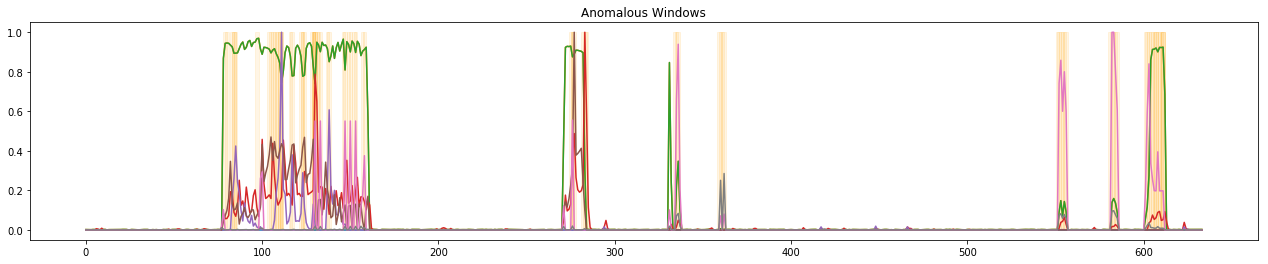

In [241]:
find_model(m, x_train, x_valid, x_test, epochs, window_size, signal_test)


In [242]:
def get_data_others():
    path = "mem.txt"
    df = pd.read_csv(path, sep=',', header=None)
    df = df.drop([0], 1)
    if(df.isnull().sum().sum()):
        df = df.fillna(df.mean())
    return df


In [230]:
zz = get_data_others()

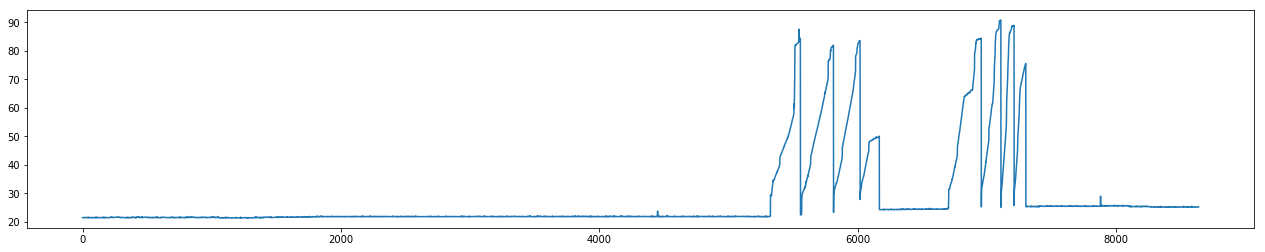

In [231]:
plt.figure(figsize=(22, 4))
plt.plot(zz)

In [234]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(zz)
signal = scaled
signal.shape

(8640, 1)

In [235]:
signal_train = signal[:6000]
signal_valid = signal[6000:7000]
signal_test = signal[6000:8640]

In [236]:
window_size = 5
m = model4(window_size, input_dim=1)
m.compile(loss='mse', optimizer='adam')
epochs = 10


Epoch 00001: val_loss improved from inf to 0.00238, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00002: val_loss did not improve from 0.00238

Epoch 00003: val_loss did not improve from 0.00238

Epoch 00004: val_loss did not improve from 0.00238

Epoch 00005: val_loss did not improve from 0.00238

Epoch 00006: val_loss did not improve from 0.00238
3.4449978192647297


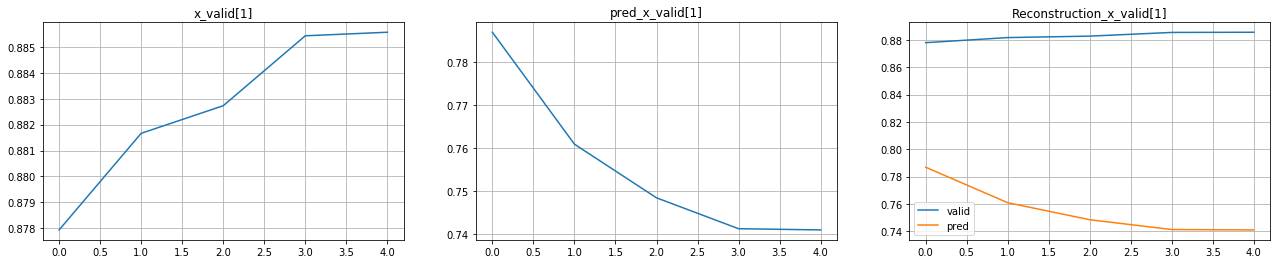

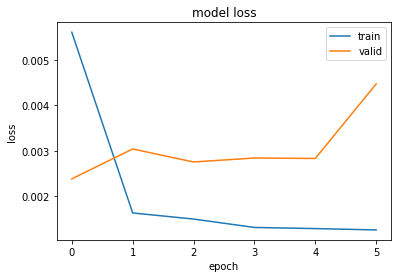

[  15   16   17   18  164  165  166  167  953  954  955  956 1091 1092
 1093 1094 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106
 1107 1108 1207 1208 1209 1210 1298 1299 1300 1301]


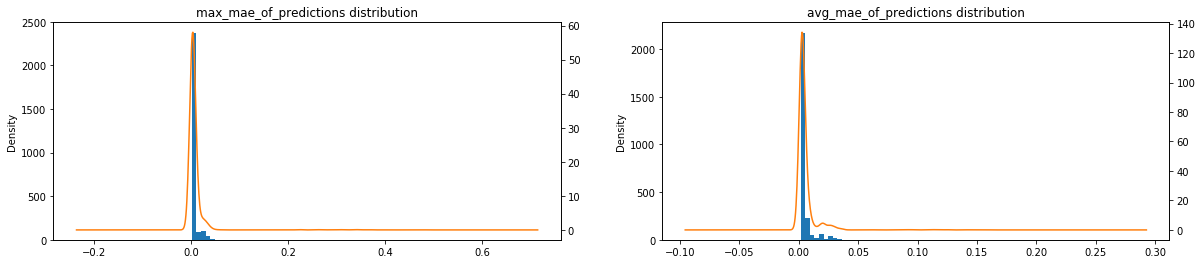

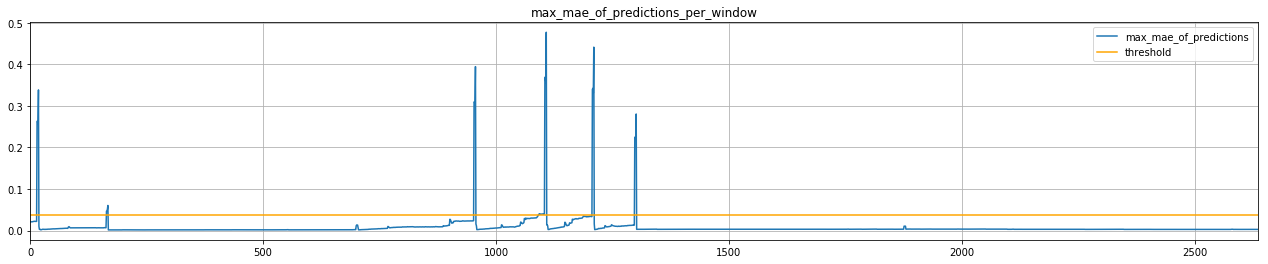

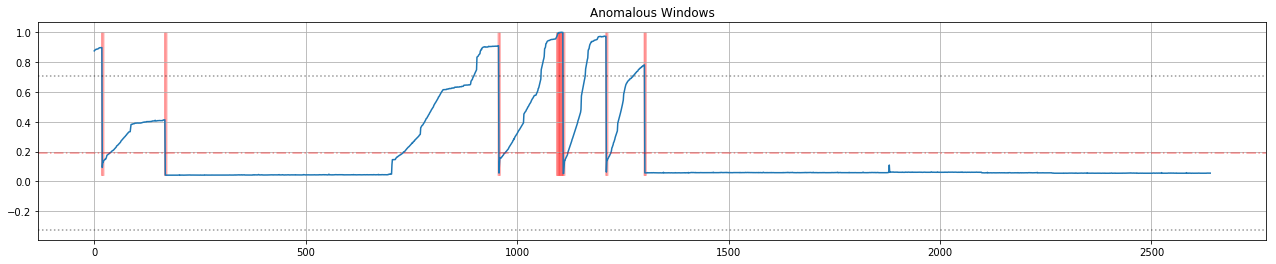

In [237]:
x_train = np.array(make_data_windows(signal_train, 5))
x_valid = np.array(make_data_windows(signal_valid, 5))
x_test = np.array(make_data_windows(signal_test, 5))
find_model(m, x_train, x_valid, x_test, epochs, window_size, signal_test)


In [243]:
zz = get_data_others()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(zz)
signal = scaled
signal.shape
signal_train = signal[:6000]
signal_valid = signal[6000:7000]
signal_test = signal[6000:8640]
window_size = 5
m = model4(window_size, input_dim=1)
m.compile(loss='mse', optimizer='adam')
epochs = 2
x_train = np.array(make_data_windows(signal_train, 5))
x_valid = np.array(make_data_windows(signal_valid, 5))
x_test = np.array(make_data_windows(signal_test, 5))


Epoch 00001: val_loss improved from inf to 0.00322, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00002: val_loss improved from 0.00322 to 0.00310, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00001: val_loss improved from 0.00310 to 0.00282, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00002: val_loss improved from 0.00282 to 0.00274, saving model to lstm.autoencoder.weights.best.hdf5
0.6227670510609945

Epoch 00001: val_loss improved from 0.00274 to 0.00248, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00002: val_loss improved from 0.00248 to 0.00233, saving model to lstm.autoencoder.weights.best.hdf5
0.5534233967463176

Epoch 00001: val_loss did not improve from 0.00233

Epoch 00002: val_loss did not improve from 0.00233
0.6097464601198832

Epoch 00001: val_loss did not improve from 0.00233

Epoch 00002: val_loss did not improve from 0.00233
0.5507686535517374

Epoch 00001: val_loss did not improve from 0.00233

Epoch 00002: val_lo

KeyboardInterrupt: 

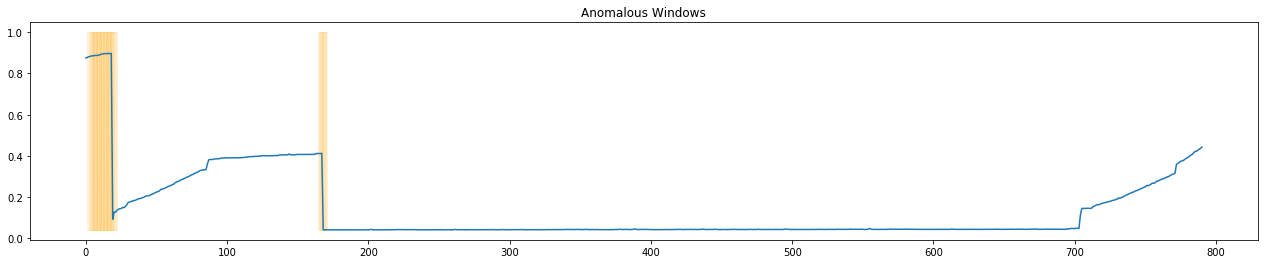

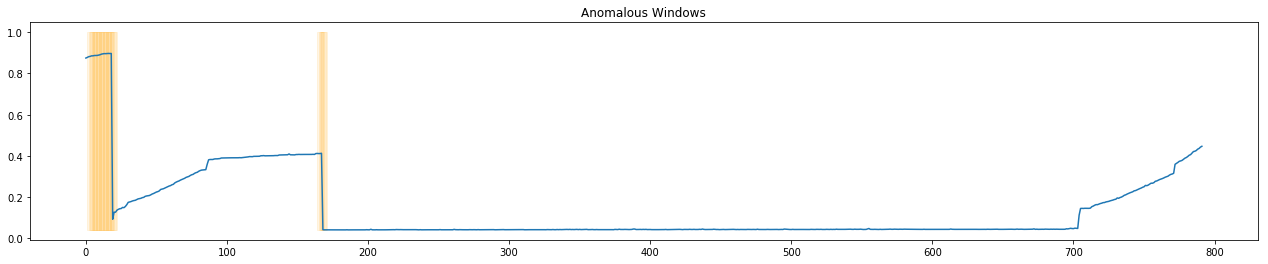

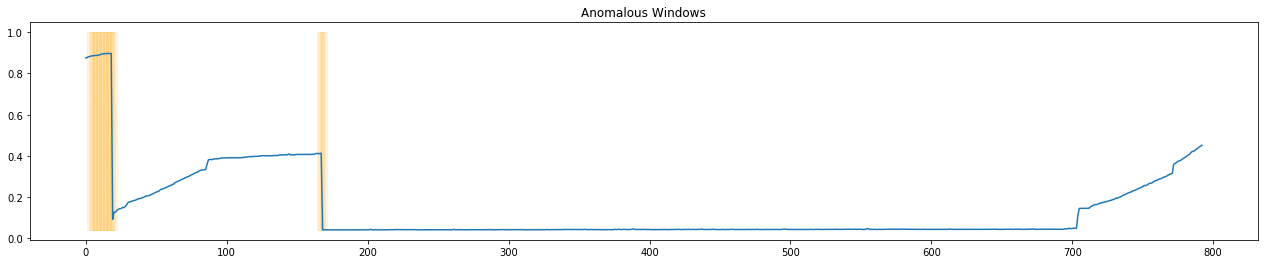

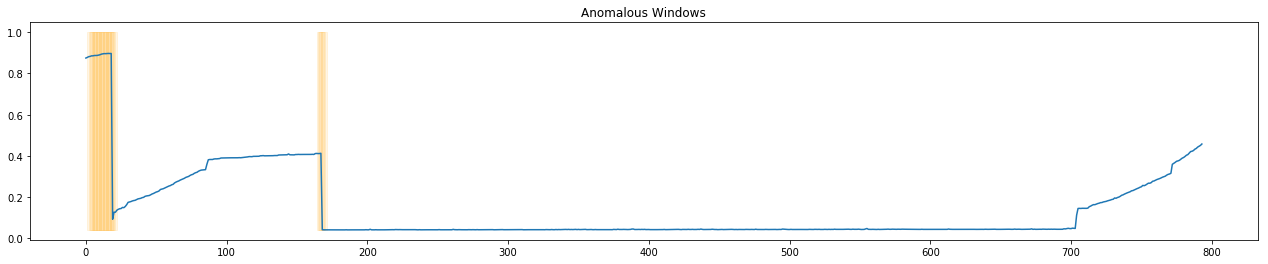

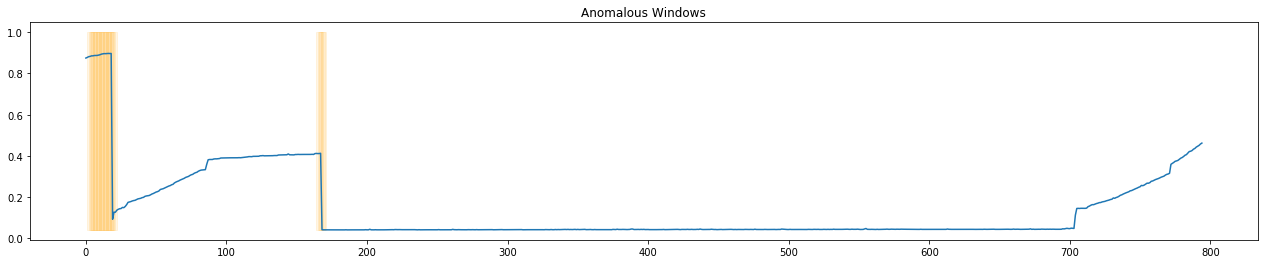

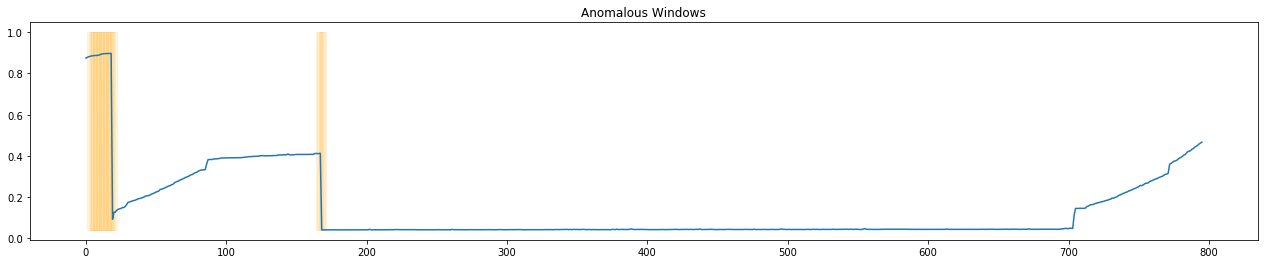

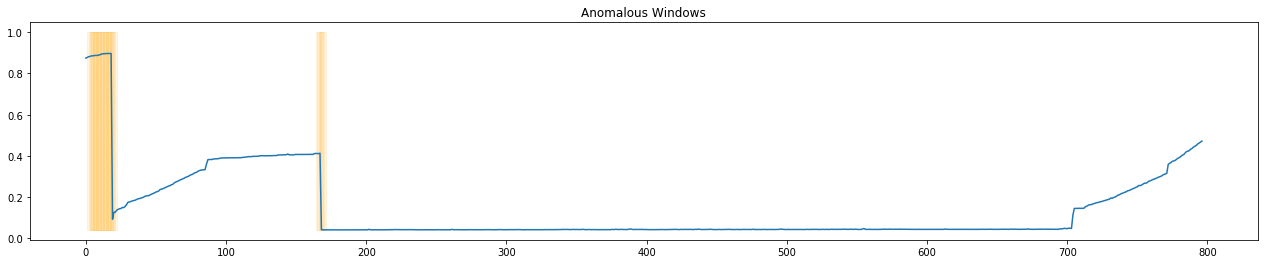

In [244]:
find_model_online(m, x_train, x_valid, x_test, epochs, window_size, signal_test)